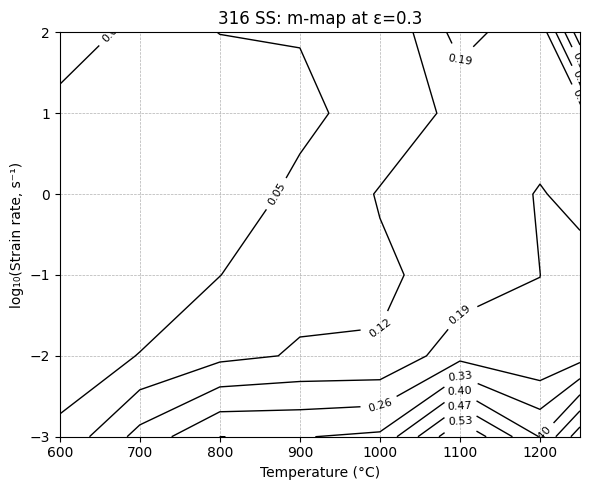

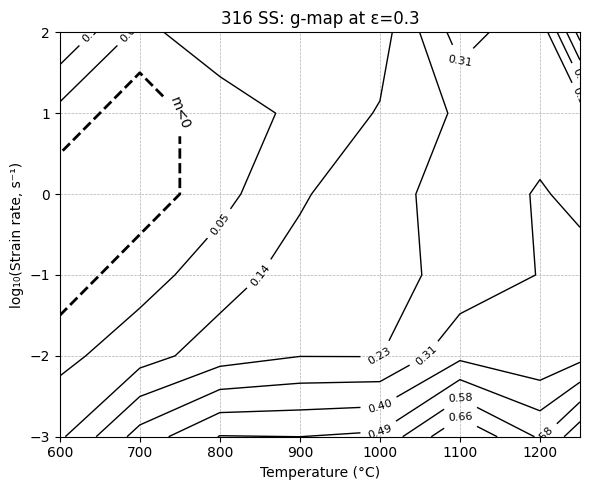

Saved processing maps to /content/316_processing_maps.pdf


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re

# -----------------------------------------------------------------------------
# --- CONFIGURATION -----------------------------------------------------------
# -----------------------------------------------------------------------------
INPUT_FILE    = '/content/316L.csv'     # your CSV file
STRAIN_COL    = 'Strain'
STRAIN_VALUE  = 0.3                     # set the true‐strain you want

# -----------------------------------------------------------------------------
# --- LOAD DATA ---------------------------------------------------------------
# -----------------------------------------------------------------------------
df = pd.read_csv(INPUT_FILE)

# -----------------------------------------------------------------------------
# --- IDENTIFY COLUMNS --------------------------------------------------------
# -----------------------------------------------------------------------------
# 1) Strain‐rate column (first one containing “Strain Rate”)
rate_cols = [c for c in df.columns if 'Strain Rate' in c]
if not rate_cols:
    raise KeyError("No 'Strain Rate' column found in CSV")
RATE_COL = rate_cols[0]

# 2) Strain column
if STRAIN_COL not in df.columns:
    raise KeyError(f"No '{STRAIN_COL}' column found in CSV")

# -----------------------------------------------------------------------------
# --- FILTER TO SELECTED STRAIN -----------------------------------------------
# -----------------------------------------------------------------------------
df_s = df[df[STRAIN_COL] == STRAIN_VALUE].sort_values(RATE_COL)
if df_s.empty:
    raise ValueError(f"No data for {STRAIN_COL}={STRAIN_VALUE}")

# -----------------------------------------------------------------------------
# --- DETECT TEMPERATURE COLUMNS ----------------------------------------------
# -----------------------------------------------------------------------------
# Match columns named like "600" or "700" or "800 °C"
temps = []
col_map = {}
for col in df_s.columns:
    s = str(col).strip()
    m = re.match(r'^(\d+)(?:\s*°\s*C)?$', s)
    if m:
        T = int(m.group(1))
        temps.append(T)
        col_map[T] = col
if not temps:
    raise KeyError("No temperature columns found")
temps = sorted(set(temps))

# -----------------------------------------------------------------------------
# --- PREPARE GRID -------------------------------------------------------------
# -----------------------------------------------------------------------------
rates     = df_s[RATE_COL].values
log_rates = np.log10(rates)
T_grid, LR_grid = np.meshgrid(temps, log_rates)

# -----------------------------------------------------------------------------
# --- COMPUTE m AND g ---------------------------------------------------------
# -----------------------------------------------------------------------------
M = np.zeros((len(rates), len(temps)))
for j, T in enumerate(temps):
    sigma     = df_s[col_map[T]].values
    log_sigma = np.log(sigma)
    m_arr     = np.zeros_like(log_sigma)
    # central differences
    if len(rates) > 2:
        m_arr[1:-1] = (
            log_sigma[2:] - log_sigma[:-2]
        ) / (
            np.log(rates[2:]) - np.log(rates[:-2])
        )
    # endpoints
    m_arr[0]  = (log_sigma[1]  - log_sigma[0])  / (log_rates[1]  - log_rates[0])
    m_arr[-1] = (log_sigma[-1] - log_sigma[-2]) / (log_rates[-1] - log_rates[-2])
    M[:, j]   = m_arr

G = 2 * M / (M + 1)

# -----------------------------------------------------------------------------
# --- SAVE PROCESSING MAPS TO PDF ---------------------------------------------
# -----------------------------------------------------------------------------
out_pdf = '/content/316_processing_maps.pdf'
with PdfPages(out_pdf) as pdf:
    # -- m‐map (B&W) --
    fig1 = plt.figure(figsize=(6,5))
    levels_m = np.linspace(np.nanmin(M), np.nanmax(M), 10)
    cs1 = plt.contour(T_grid, LR_grid, M,
                      levels=levels_m,
                      colors='black', linewidths=1)
    plt.clabel(cs1, fmt='%.2f', fontsize=8)
    plt.title(f'316 SS: m‐map at ε={STRAIN_VALUE}')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('log₁₀(Strain rate, s⁻¹)')
    plt.grid(linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    pdf.savefig(fig1)
    plt.close(fig1)

    # -- g‐map + instability boundary (B&W) --
    fig2 = plt.figure(figsize=(6,5))
    levels_g = np.linspace(np.nanmin(G), np.nanmax(G), 10)
    cs2 = plt.contour(T_grid, LR_grid, G,
                      levels=levels_g,
                      colors='black', linewidths=1)
    plt.clabel(cs2, fmt='%.2f', fontsize=8)
    unstable = (M < 0).astype(int)
    csu = plt.contour(T_grid, LR_grid, unstable,
                      levels=[0.5],
                      colors='black',
                      linewidths=2,
                      linestyles='--')
    plt.clabel(csu, fmt='m<0', inline=True, fontsize=10)
    plt.title(f'316 SS: g‐map at ε={STRAIN_VALUE}')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('log₁₀(Strain rate, s⁻¹)')
    plt.grid(linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    pdf.savefig(fig2)
    plt.close(fig2)

print(f"Saved processing maps to {out_pdf}")
